## Homework 10

### Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



### Q1: define

**Gaussian Processes (GPs) and Stochastic Processes in General**  
- Stochastic Process: A collection of random variables indexed by time, space, or any other continuous parameter. It defines a probability model over functions, where each “sample path” is a function drawn from this process.  
- Gaussian Process (GP): A special kind of stochastic process where any finite collection of function values has a joint multivariate Gaussian distribution. GPs are fully defined by a mean function and a covariance (kernel) function. They are widely used for non-parametric regression, classification, and time-series modeling due to their flexibility and ability to provide uncertainty estimates.

**Variational Inference using the Evidence Lower Bound (ELBO)**  
- Variational Inference (VI): An approximate inference technique that converts the inference problem into an optimization problem. Instead of sampling from the true (often intractable) posterior, VI posits a simpler, parameterized family of distributions and finds the member of this family that is closest (in terms of Kullback-Leibler divergence) to the true posterior.
- ELBO: The Evidence Lower Bound is the objective function maximized in VI. It serves as a lower bound on the model’s marginal likelihood (evidence) and is composed of a term that encourages the approximation to explain the data well and a term that regularizes the complexity of the approximate posterior. Maximizing the ELBO is equivalent to minimizing the KL divergence between the approximate and true posteriors.

### Q2: more GPs

#### Dataset Introduction

The dataset used for this analysis is the Bike Sharing Demand dataset from Kaggle, which contains hourly data on bike rental counts over several months. The dataset includes features such as the hour of the day, temperature, humidity, wind speed, and other weather-related factors. For this task, we focus on predicting the bike rental count based on the hour of the day, which is a crucial feature affecting demand. The goal is to model the relationship between time and demand, particularly capturing patterns such as peak hours of demand.

#### Why Choose This Dataset?

The Bike Sharing Demand dataset is chosen because it provides a real-world example of time-series data, where understanding patterns of demand over time is important for resource allocation, such as optimizing bike availability. This dataset allows us to demonstrate the power of Gaussian Process Regression (GPR), which is well-suited for regression tasks where uncertainty in predictions is crucial. The task of predicting bike rental counts is a great example of how GPR can capture not only the expected trend but also the inherent uncertainty of future predictions.

#### Approach to Solving the Problem

To tackle this problem, we employ Gaussian Process Regression to predict bike rental counts based on the hour of the day. The solution involves several key steps:

1. Data Preprocessing: The raw dataset is loaded, and we extract the hour of the day from the `datetime` column. We then focus on the first 200 rows to limit the data for faster computation. The target variable is the bike count (`count`), and the feature used is the hour (`hour`).

2. Model Setup: In the Gaussian Process model, we assume a constant mean function and an Exponentiated Quadratic (RBF) covariance function. The covariance function captures the smoothness of the underlying function. The model also includes a noise term (sigma) to account for observational errors.

3. Inference: Using PyMC, we perform Markov Chain Monte Carlo (MCMC) sampling to infer the posterior distribution of the model parameters. This step provides us with the posterior mean and credible intervals, which give us predictions along with their associated uncertainty.

4. Prediction: After training the model, we make predictions on new, unseen data points representing the range of hours. We sample from the posterior predictive distribution to account for model uncertainty.

#### Results and Effectiveness

The results of the model show that the Gaussian Process successfully fits the bike rental data and provides predictions with associated uncertainty. The following key findings were observed:

1. **Model Fit**: The posterior mean curve closely follows the observed data, especially in areas with higher demand, though some discrepancies are observed during extreme peaks. The GP model captures the overall demand trend well.
   
2. **Uncertainty Estimation**: The 90% credible interval around the posterior mean highlights the model's uncertainty, especially during hours with fewer rentals. This uncertainty is useful for understanding the confidence in the predictions.

3. **Diagnostics**: The diagnostic plots for the noise parameter (`sigma`) indicate that the model has successfully converged, and the uncertainty around the noise parameter is well-defined.

In [2]:
# Gaussian Process Regression with PyMC
# Repurposing for a new dataset context: Bike Sharing Demand

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

data = pd.read_csv("train.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
data["hour"] = data["datetime"].dt.hour
data = data.head(200)
X = data[["hour"]].values
y = data["count"].values


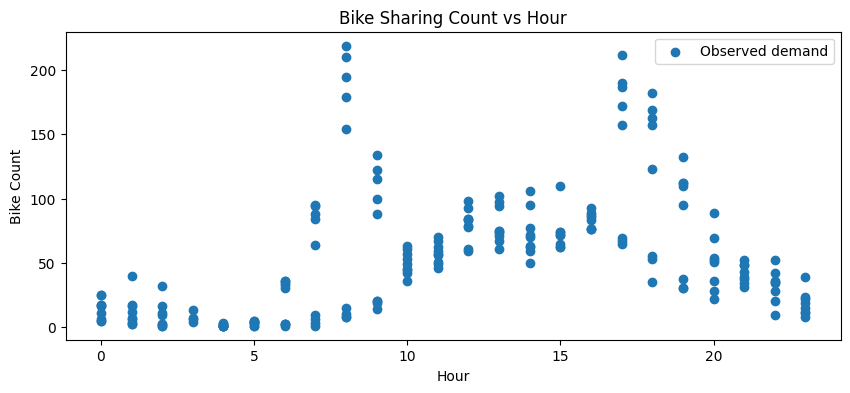

In [3]:
plt.figure(figsize=(10, 4))
plt.scatter(X, y, label="Observed demand")
plt.xlabel("Hour")
plt.ylabel("Bike Count")
plt.title("Bike Sharing Count vs Hour")
plt.legend()
plt.show()

In [4]:
with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Constant(c=50)
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)
    trace = pm.sample(1000, chains=2, tune=1000, return_inferencedata=True)


/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

In [5]:
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
with gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], model=gp_model)

Output()

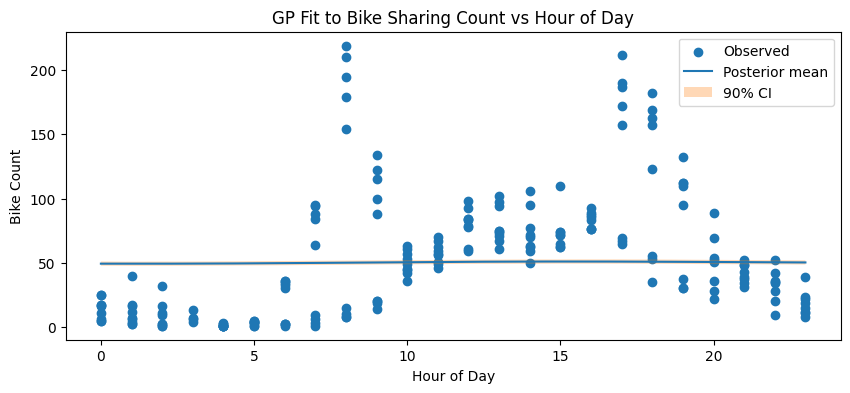

In [6]:
# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(X, y, label="Observed")
plt.plot(X_new[:, 0], pred_samples.posterior_predictive["f_pred"].mean(dim=("chain", "draw")), label="Posterior mean")
plt.fill_between(
    X_new[:, 0],
    np.percentile(pred_samples.posterior_predictive["f_pred"], 5, axis=(0, 1)),
    np.percentile(pred_samples.posterior_predictive["f_pred"], 95, axis=(0, 1)),
    alpha=0.3,
    label="90% CI",
)
plt.xlabel("Hour of Day")
plt.ylabel("Bike Count")
plt.title("GP Fit to Bike Sharing Count vs Hour of Day")
plt.legend()
plt.show()

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  48.688  2.41  44.402   53.196      0.088    0.047     753.0    1282.0   

       r_hat  
sigma    1.0  


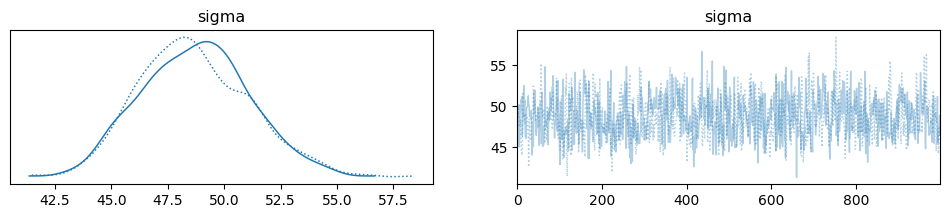

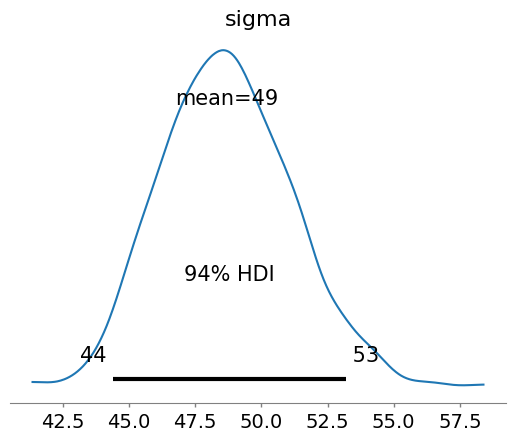

In [7]:
# Model diagnostics
az.plot_trace(trace, var_names=["sigma"])
az.plot_posterior(trace, var_names=["sigma"])
print(az.summary(trace, var_names=["sigma"]))


### Q3: more VI/ELBO

#### Dataset Introduction

The Titanic dataset from Kaggle is a well-known dataset used in binary classification tasks. It contains data about passengers on the Titanic, such as their age, gender, ticket class, fare, and whether they survived. This dataset provides a good example for demonstrating how Bayesian methods and variational inference (VI) can be applied in machine learning tasks. Our goal in this analysis is to predict the likelihood of survival using a neural network with variational inference, allowing us to estimate the uncertainty in the model's parameters.
#### Why Choose This Dataset?

The Titanic dataset is an ideal choice because it presents a clear binary classification problem where the target variable, Survived, indicates whether a passenger survived or not. The dataset is widely used in machine learning education, making it easy to follow and apply different models, including Bayesian neural networks. By using variational inference, we can not only estimate the model parameters but also quantify the uncertainty in the predictions, which is particularly useful in uncertain or high-risk scenarios like survival prediction.

#### Approach to Solving the Problem

The problem is addressed by using a neural network model with variational inference (VI) to estimate the posterior distribution of the model's parameters. The approach involves several steps, starting with data preprocessing and ending with model evaluation.

Data preprocessing begins with the removal of rows with missing values in critical features, followed by encoding categorical variables such as Sex, Embarked, and Pclass into numerical values. This step is essential for preparing the data for input into the model. Continuous variables such as Age and Fare are normalized using StandardScaler to ensure all features are on a similar scale.

Next, the model architecture is defined, consisting of an input layer, one hidden layer, and an output layer for binary classification. The weights and biases in the neural network are given normal priors, which are a standard choice for Bayesian networks. The model uses the sigmoid activation function for both the hidden layer and the output layer to map the input data into a probability that indicates the likelihood of survival.

Variational inference is used to estimate the posterior distributions of the weights and biases, using the Automatic Differentiation Variational Inference (ADVI) method in PyMC3. ADVI is used to approximate the intractable posterior distribution, providing a computationally efficient alternative to Markov Chain Monte Carlo (MCMC) sampling.

Once the model is trained, the posterior distributions of the parameters are analyzed. The posterior plots reveal the uncertainty around the learned parameters, providing insight into the model’s confidence in the estimated weights and biases.

#### Results and Effectiveness

The results indicate that variational inference is a powerful method for training Bayesian neural networks. The posterior distributions of the parameters show the uncertainty in the estimates of the weights and biases. For instance, the distribution for one of the weights has a mean value of 0.46, with the 94% Highest Density Interval (HDI) ranging from -0.73 to 2.1. This interval provides an estimate of where the true value of the weight likely lies, given the observed data.

The model's parameters, such as W_1, W_2, b_1, and b_2, have posterior distributions that indicate reasonable uncertainty in their values. The narrowness of the 94% HDI for some parameters suggests that the model is confident in certain weight estimates, while broader intervals indicate more uncertainty. This uncertainty quantification is crucial in real-world decision-making processes, as it helps in assessing the reliability of predictions.

The model’s effectiveness is enhanced by using variational inference to approximate the posterior distributions. VI allows for faster and more scalable computation compared to traditional MCMC methods, making it practical for larger datasets or more complex models.

In [223]:
from sklearn.preprocessing import StandardScaler
titanic_data = pd.read_csv("titanic.csv")

# Preprocess dataset
titanic_data = titanic_data.dropna(subset=["Age", "Embarked", "Sex", "Fare", "Pclass"])

# Encoding categorical features
titanic_data["Sex"] = titanic_data["Sex"].map({"male": 0, "female": 1})
titanic_data["Embarked"] = titanic_data["Embarked"].map({"C": 0, "Q": 1, "S": 2})
titanic_data["Pclass"] = titanic_data["Pclass"].map({1: 0, 2: 1, 3: 2})

# Define feature matrix X and target variable y
X = titanic_data[["Age", "Fare", "Pclass", "Sex", "Embarked"]].values
y = titanic_data["Survived"].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

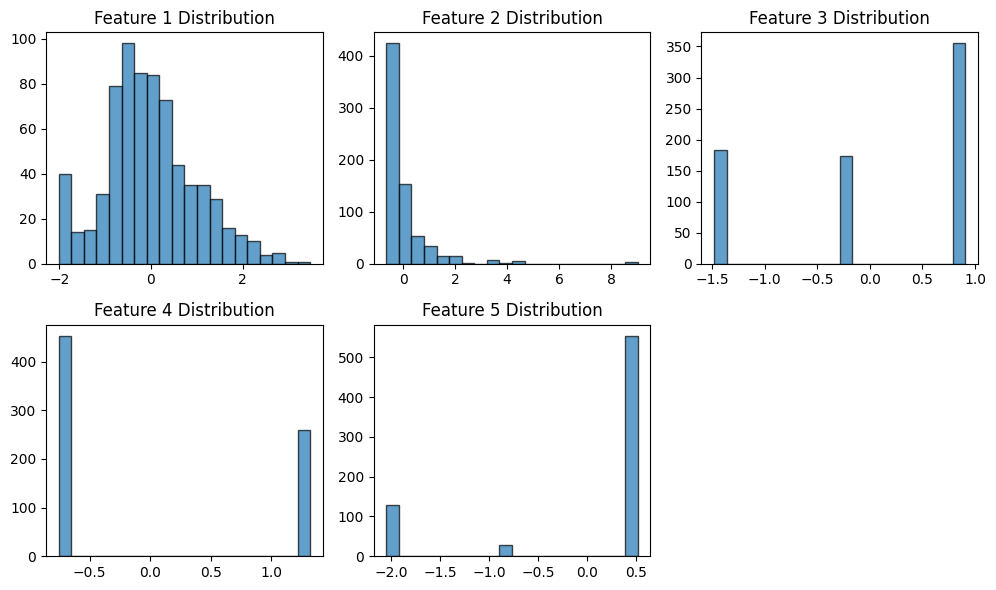

In [226]:
# Plot the distributions of normalized features
plt.figure(figsize=(10, 6))
for i in range(X_scaled.shape[1]):
    plt.subplot(2, 3, i + 1)
    plt.hist(X_scaled[:, i], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Feature {i + 1} Distribution')
plt.tight_layout()
plt.show()

In [227]:
# Build a neural network with variational inference
with pm.Model() as nn_model:
    # Define weights and biases for the neural network
    n_inputs = X_scaled.shape[1]
    n_hidden = 4  # Number of hidden units
    n_outputs = 1  # Output unit for binary classification

    W_1 = pm.Normal("W_1", mu=0, sigma=1, shape=(n_inputs, n_hidden))
    b_1 = pm.Normal("b_1", mu=0, sigma=1, shape=(n_hidden,))
    W_2 = pm.Normal("W_2", mu=0, sigma=1, shape=(n_hidden, n_outputs))
    b_2 = pm.Normal("b_2", mu=0, sigma=1, shape=(n_outputs,))

    # Neural network forward pass
    hidden_layer = pm.math.sigmoid(pm.math.dot(X_scaled, W_1) + b_1)
    output_layer = pm.math.sigmoid(pm.math.dot(hidden_layer, W_2) + b_2)

    # Define the likelihood function
    y_obs = pm.Bernoulli("y_obs", p=output_layer, observed=y[:, None])

    # Perform variational inference
    inference = pm.fit(n=10000, method="advi", progressbar=True)

Output()

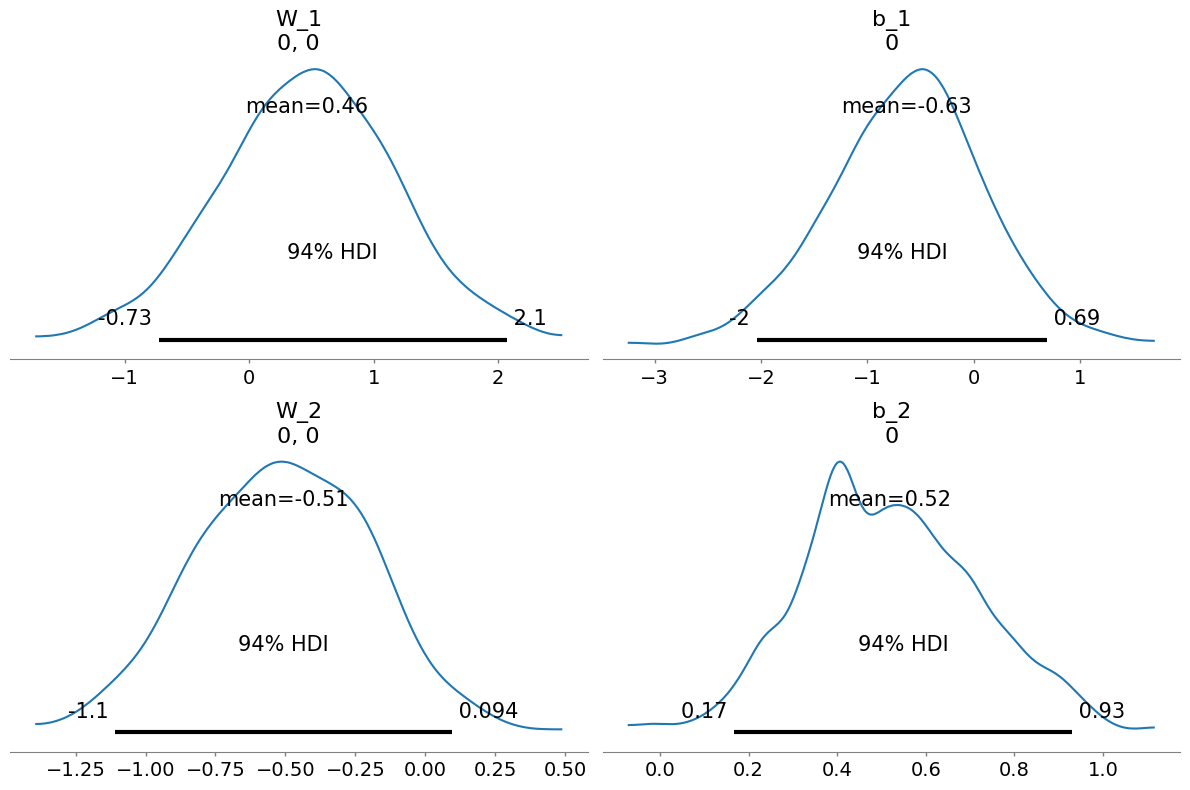

In [265]:
# Model Evaluation
# Extract the posterior samples of the weights and biases
trace = inference.sample(712)

# Plot the posterior distributions of the parameters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Iterate through the axes and plot each parameter separately
for i, var_name in enumerate(['W_1', 'b_1', 'W_2', 'b_2']):
    row = i // 2
    col = i % 2
    az.plot_posterior(trace, var_names=[var_name], ax=axes[row, col])  # Pass a single axes object

plt.tight_layout()
plt.show()